# Binary classification of movie reviews

We will use a basic application of transfer learning using TensorFlow Hub

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from utls import auto_reload; auto_reload()
from utls import tf_status
from utls import plot

In [2]:
tf_status()

Version:  2.2.0
Eager mode:  True
Hub version:  0.8.0
GPU is NOT AVAILABLE


Download the IMDB dataset. Use a 60:40 split of the training set for validation

In [3]:
train_data, validation_data, test_data = tfds.load(
    name='imdb_reviews',
    split=('train[:60%]', 'train[:60%]', 'test'),
    as_supervised=True
)

Shuffling and writing examples to /home/juvid/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNI1PZG/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/juvid/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNI1PZG/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/juvid/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNI1PZG/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /home/juvid/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Explore data

In [5]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))

In [9]:
train_examples_batch[0], train_labels_batch[0]

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

0 = negative review

In [10]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

## Build the model

As a first layer, we'll use a pre-trained text embedding called [Swivel](https://arxiv.org/abs/1602.02215) which uses a 20-dimensional embedding space. We'll download the model from TensorFlow Hub

In [11]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

In [12]:
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True
                           )

In [13]:
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

Each sentence becomes a point in 20-dimensional space.

Now let's build the full model, with a simple densely-connected neural network with 1 hidden layer.

In [14]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


Since this is a binary classification, we can use `binary_crossentropy` as the loss function.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

## Train the model

Train the model for 20 epochs in mini-batches of 512 samples. While trainng, monitor the model's loss and accuracy on the validation set.

In [20]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1
                   )

Epoch 1/20
30/30 [==============================] - 4s 133ms/step - loss: 0.6808 - accuracy: 0.5816 - val_loss: 0.6238 - val_accuracy: 0.6259
Epoch 2/20
30/30 [==============================] - 4s 126ms/step - loss: 0.6003 - accuracy: 0.6529 - val_loss: 0.5734 - val_accuracy: 0.6759
Epoch 3/20
30/30 [==============================] - 4s 127ms/step - loss: 0.5552 - accuracy: 0.6949 - val_loss: 0.5315 - val_accuracy: 0.7077
Epoch 4/20
30/30 [==============================] - 4s 127ms/step - loss: 0.5157 - accuracy: 0.7265 - val_loss: 0.4924 - val_accuracy: 0.7500
Epoch 5/20
30/30 [==============================] - 4s 127ms/step - loss: 0.4750 - accuracy: 0.7621 - val_loss: 0.4547 - val_accuracy: 0.7606
Epoch 6/20
30/30 [==============================] - 4s 124ms/step - loss: 0.4386 - accuracy: 0.7878 - val_loss: 0.4176 - val_accuracy: 0.7963
Epoch 7/20
30/30 [==============================] - 4s 126ms/step - loss: 0.4046 - accuracy: 0.8109 - val_loss: 0.3850 - val_accuracy: 0.8307
Epoch 

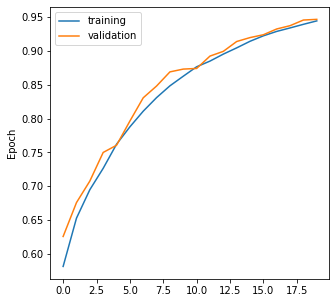

In [30]:
fig, ax = plot()
ax.plot(history.history['accuracy'], label='training')
ax.plot(history.history['val_accuracy'], label='validation')
ax.set_ylabel('Accuracy')
ax.set_ylabel('Epoch')
ax.legend();

## Evaluate the model

In [31]:
results = model.evaluate(test_data.batch(512), verbose=2)

49/49 - 2s - loss: 0.3169 - accuracy: 0.8578
